In [49]:
import math
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp
import jax.scipy.stats as stats
from jax import jacfwd, jacrev
from jax import vmap, grad, jit, random
from jax.tree_util import tree_map, tree_flatten, tree_unflatten, tree_leaves

from flax import nnx
import optax
import pcax

from tqdm.notebook import tqdm
from tqdm.notebook import trange

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

import os
os.chdir('../methods')
import lsci, supr, conf, uqno, prob_don, quant_don, gaus
os.chdir('../gpsims')

os.chdir('../models_and_metrics')
from models import *
from metrics import * 
from utility import *
os.chdir('../gpsims')

In [76]:
# generate data
kernel = jnp.ones(5)/5

n, p = 500, 100
rng0 = 100
key1 = random.PRNGKey(rng0 + 1)
key2 = random.PRNGKey(rng0 + 2)
key3 = random.PRNGKey(rng0 + 3)

t = jnp.linspace(0, 1, p + 8)
s = jnp.linspace(-2*math.pi, 2*math.pi, n + 1)

amp = jnp.sin(s)
sd = jnp.sin(s)

f = jnp.sin(2 * math.pi * t)
f = 10 + amp[:,None] * f[None,:]

xtrain = f + 0.25 * (1.15 + sd)[:,None] * random.normal(key1, f.shape)
xtrain = conv(conv(xtrain.squeeze(), kernel), kernel)
xtrain, ytrain = split_data(xtrain, 1, 1)
xtrain = xtrain[:,:,:,None]
ytrain = ytrain[:,:,:,None]

xval = f + 0.25 * (1.15 + sd)[:,None] * random.normal(key2, f.shape)
xval = conv(conv(xval.squeeze(), kernel), kernel)

xval, yval = split_data(xval, 1, 1)
xval = xval[:,:,:,None]
yval = yval[:,:,:,None]

xtest = f + 0.25 * (1.15 + sd)[:,None] * random.normal(key3, f.shape)
xtest = conv(conv(xtest.squeeze(), kernel), kernel)

xtest, ytest = split_data(xtest, 1, 1)
xtest = xtest[:,:,:,None]
ytest = ytest[:,:,:,None]

sigma = 0.25 * (1.15 + sd)

In [77]:
xtrain = torch.tensor(xtrain[:,:,:,0])
ytrain = torch.tensor(ytrain[:,:,:,0])
xval = torch.tensor(xval[:,:,:,0])
yval = torch.tensor(yval[:,:,:,0])
xtest = torch.tensor(xtest[:,:,:,0])
ytest = torch.tensor(ytest[:,:,:,0])

In [78]:
train_data = TensorDataset(xtrain, ytrain)
train_loader = DataLoader(train_data, batch_size = 30, shuffle = True)

In [85]:
import neuralop as op
from neuralop.models import FNO, LocalFNO, UNO, TFNO

loss_fn = nn.MSELoss()

fno = FNO(n_modes=(16,), 
             hidden_channels=64, 
             in_channels=1, 
             out_channels=1)
optim_fno = torch.optim.Adam(fno.parameters(), lr = 1e-3)

tno = TFNO(n_modes=(16,), 
               hidden_channels=64, 
               in_channels=1, 
               out_channels=1,
               factorization='tucker',
               implementation='factorized',
               rank=0.05)
optim_tno = torch.optim.Adam(tno.parameters(), lr = 1e-3)

uno = TFNO(n_modes=(16,), 
           hidden_channels=64, 
           in_channels=1, 
           out_channels=1,
           out_uno_channels = [32,64,64,32])
optim_uno = torch.optim.Adam(uno.parameters(), lr = 1e-3)

In [86]:
epochs = 20
for _ in trange(epochs):
    for xt, yt in tqdm(train_loader, leave = False):  
        yhat = fno(xt)
        loss = loss_fn(yhat, yt)
        loss.backward()
        optim_fno.step()
        optim_fno.zero_grad()

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

In [87]:
epochs = 20
for _ in trange(epochs):
    for xt, yt in tqdm(train_loader, leave = False):  
        yhat = tno(xt)
        loss = loss_fn(yhat, yt)
        loss.backward()
        optim_tno.step()
        optim_tno.zero_grad()

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

In [88]:
epochs = 20
for _ in trange(epochs):
    for xt, yt in tqdm(train_loader, leave = False):  
        yhat = uno(xt)
        loss = loss_fn(yhat, yt)
        loss.backward()
        optim_uno.step()
        optim_uno.zero_grad()

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

In [94]:
with torch.no_grad():
    yval_fno = jnp.array(np.array(fno(xval).squeeze()))
    yval_tno = jnp.array(np.array(tno(xval).squeeze()))
    yval_uno = jnp.array(np.array(uno(xval).squeeze()))
    ytest_fno = jnp.array(np.array(fno(xtest).squeeze()))
    ytest_tno = jnp.array(np.array(tno(xtest).squeeze()))
    ytest_uno = jnp.array(np.array(uno(xtest).squeeze()))

In [108]:
nproj = npc = 50
gamma = 0.1
alpha = 0.1
nval = xval.shape[0]

lsci_fno_risk, lsci_fno_width = [], []
lsci_tno_risk, lsci_tno_width = [], []
lsci_uno_risk, lsci_uno_width = [], []

xval = jnp.array(np.array(xval)).squeeze()
yval = jnp.array(np.array(yval)).squeeze()
xtest = jnp.array(np.array(xtest)).squeeze()
ytest = jnp.array(np.array(ytest)).squeeze()

rval_fno = (yval - yval_fno).squeeze()
rval_tno = (yval - yval_tno).squeeze()
rval_uno = (yval - yval_uno).squeeze()

rtest_fno = (ytest - ytest_fno).squeeze()
rtest_tno = (ytest - ytest_tno).squeeze()
rtest_uno = (ytest - ytest_uno).squeeze()

state_fno = lsci.lsci_state(xval, rval_fno, npc)
state_tno = lsci.lsci_state(xval, rval_tno, npc)
state_uno = lsci.lsci_state(xval, rval_uno, npc)

pca_state_fno = state_fno[-1]
pca_state_tno = state_tno[-1]
pca_state_uno = state_uno[-1]

for i in trange(0, ytest.shape[0]):
    
    # LSCI
    lsc1_lower, lsc1_upper = lsci.lsci_band(xtest[i].squeeze(), state_fno, alpha, 2000, gamma)
    lsci_fno_risk.append(risk(lsc1_lower, lsc1_upper, rtest_fno[i]))
    lsci_fno_width.append(jnp.median(lsc1_upper - lsc1_lower))
    
    # LSCI
    lsc2_lower, lsc2_upper = lsci.lsci_band(xtest[i].squeeze(), state_tno, alpha, 2000, gamma)
    lsci_tno_risk.append(risk(lsc2_lower, lsc2_upper, rtest_tno[i]))
    lsci_tno_width.append(jnp.median(lsc2_upper - lsc2_lower))
    
    # LSCI
    lsc3_lower, lsc3_upper = lsci.lsci_band(xtest[i].squeeze(), state_uno, alpha, 2000, gamma)
    lsci_uno_risk.append(risk(lsc3_lower, lsc3_upper, rtest_uno[i]))
    lsci_uno_width.append(jnp.median(lsc3_upper - lsc3_lower))

lsci_fno_risk, lsci_fno_width = np.array(lsci_fno_risk), np.array(lsci_fno_width)
lsci_tno_risk, lsci_tno_width = np.array(lsci_tno_risk), np.array(lsci_tno_width)
lsci_uno_risk, lsci_uno_width = np.array(lsci_uno_risk), np.array(lsci_uno_width)

  0%|          | 0/500 [00:00<?, ?it/s]

In [113]:
# plt.boxplot([lsci_fno_risk, lsci_tno_risk, lsci_uno_risk])
# plt.show()

In [111]:
noise_sd = sigma[1:]
gamma = 0.99

risk_control = np.mean(lsci_fno_risk >= gamma), \
               np.mean(lsci_tno_risk >= gamma), \
               np.mean(lsci_uno_risk >= gamma)

width = np.mean(lsci_fno_width), \
        np.mean(lsci_tno_width), \
        np.mean(lsci_uno_width)

risk_cor = np.corrcoef([noise_sd, lsci_fno_risk])[0,1], \
           np.corrcoef([noise_sd, lsci_tno_risk])[0,1], \
           np.corrcoef([noise_sd, lsci_uno_risk])[0,1]

width_cor = np.corrcoef([noise_sd, lsci_fno_width])[0,1], \
            np.corrcoef([noise_sd, lsci_tno_width])[0,1], \
            np.corrcoef([noise_sd, lsci_uno_width])[0,1]

metrics = np.array([risk_control, risk_cor, width, width_cor]).T

In [112]:
for i in range(metrics.shape[0]):
    for j in range(metrics.shape[1]):
        val = f'{np.round(np.nan_to_num(metrics[i,j]), 3):.3f}'
        if j < 3:
            val += ' & '
            print(val, end = '')
        else:
            val += ' \\\\'
            print(val)

0.946 & -0.012 & 0.782 & 0.994 \\
0.952 & -0.020 & 0.911 & 0.995 \\
0.960 & 0.015 & 0.894 & 0.994 \\


In [155]:
metrics2 = metrics[:,:,None] + 0.1 * np.random.randn(3, 4, 100)

In [157]:
# plt.boxplot(metrics2[:,0].T)
# plt.show()

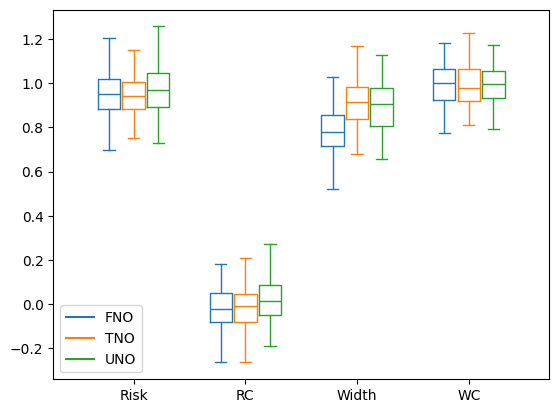

In [158]:
def set_box_color(bp, color):
    plt.setp(bp['boxes'], color=color)
    plt.setp(bp['whiskers'], color=color)
    plt.setp(bp['caps'], color=color)
    plt.setp(bp['medians'], color=color)

plt.figure()

bp_fno = plt.boxplot(metrics2[0,:].T, positions = np.array([0, 1, 2, 3])-0.22, sym='', widths=0.2)
bp_tno = plt.boxplot(metrics2[1,:].T, positions = [0, 1, 2, 3],sym='', widths=0.2)
bp_uno = plt.boxplot(metrics2[2,:].T, positions = np.array([0, 1, 2, 3])+0.22, sym='', widths=0.2)
set_box_color(bp_fno, 'C0') # colors are from http://colorbrewer2.org/
set_box_color(bp_tno, 'C1')
set_box_color(bp_uno, 'C2')

# draw temporary red and blue lines and use them to create a legend
plt.plot([], c='C0', label='FNO')
plt.plot([], c='C1', label='TNO')
plt.plot([], c='C2', label='UNO')
plt.legend()

plt.xticks(range(0, 4), labels = ['Risk', 'RC', 'Width', 'WC'])
# plt.xlim(-2, len(ticks)*2)
# plt.ylim(0, 8)
# plt.tight_layout()
plt.show()